## Imports and Set Up

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00


In [3]:
import os
import random
import warnings
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from colorama import Fore, Style
from IPython.display import clear_output
from lightgbm import LGBMClassifier, LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier, VotingRegressor, StackingClassifier, StackingRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import (accuracy_score, cohen_kappa_score,
                             confusion_matrix, f1_score, mean_absolute_error,
                             mean_squared_error, precision_score, recall_score,
                             classification_report, make_scorer)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     cross_val_score, ParameterGrid)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.under_sampling import NearMiss
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

from torch.utils.data import DataLoader, TensorDataset

import torch.optim.lr_scheduler as lr_scheduler
import optuna
from optuna import Trial

In [4]:
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [5]:
def set_seed(seed_value=2024):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True

set_seed(2024)

## Data Processing

### Load in Files

In [6]:
file_path = '/kaggle/input/child-mind-institute-problematic-internet-use'

In [7]:
TRAIN_CSV = f'{file_path}/train.csv'
TEST_CSV = f'{file_path}/test.csv'
SAMPLE_SUBMISSION_CSV = f'{file_path}/sample_submission.csv'
SERIES_TRAIN_DIR = f'{file_path}/series_train.parquet'
SERIES_TEST_DIR = f'{file_path}/series_test.parquet'


train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV) # 
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_CSV)

# Drop all the PCIAT variables as they are not present in the test data
for col in train_df.columns:
    if 'PCIAT' in col:
        train_df.drop(col, axis=1, inplace=True)

In [8]:
# Function to process individual time series files

# Min length of the time series is 927 (hardcoded to speed this up)
def process_time_series(file_name, directory, max_len=927):
    df = pd.read_parquet(os.path.join(directory, file_name, 'part-0.parquet'))
    df['id'] = file_name.split('=')[1]
    # Adjusted this so we get the full parquet - just concatenate all of them
    return df[:max_len]

In [9]:
# Function to load and aggregate time series data
def load_time_series_data(directory):
    file_names = os.listdir(directory)

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_time_series(fname, directory), file_names),
                            total=len(file_names)))

    return pd.concat(results, ignore_index=True) # This takes slightly longer but ok for now

In [10]:
train_series_df = load_time_series_data(SERIES_TRAIN_DIR)
# test_series_df = load_time_series_data(SERIES_TEST_DIR)

100%|██████████| 996/996 [00:21<00:00, 47.05it/s]


In [11]:
# Replace with missing for the split and then reassign the values at the end
train_df['sii'] = train_df['sii'].replace({np.nan: -1})
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=2024, stratify=train_df['sii'])
test_series_df = train_series_df[train_series_df.id.isin(test_df.id)]
train_series_df = train_series_df[train_series_df.id.isin(train_df.id)]
train_df['sii'] = train_df['sii'].replace({-1: np.nan})
test_df['sii'] = test_df['sii'].replace({-1: np.nan})


### Encoding of Time Series Data

In [12]:
# Encoder Class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, seq_len, num_layers):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.seq_len = seq_len
        self.num_layers = num_layers

        self.lstm_enc = nn.LSTM(input_size=input_size, num_layers=num_layers, hidden_size=hidden_size, dropout=dropout, batch_first=True)

    def forward(self, x):
        out, (last_h_state, last_c_state) = self.lstm_enc(x)
        # Get the last hidden state
        x_enc = last_h_state[-1, :, :]         
        return x_enc, out


# Decoder Class
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, seq_len, use_act, num_layers):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.seq_len = seq_len
        self.use_act = use_act  # Parameter to control the last sigmoid activation - depends on the normalization used.
        self.act = nn.Sigmoid()

        self.lstm_dec = nn.LSTM(input_size=hidden_size, num_layers=num_layers, hidden_size=hidden_size, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, z):
        z = z.unsqueeze(1).repeat(1, self.seq_len, 1)
        dec_out, (hidden_state, cell_state) = self.lstm_dec(z)
        dec_out = self.fc(dec_out)
        if self.use_act:
            dec_out = self.act(dec_out)

        return dec_out, hidden_state


# LSTM Auto-Encoder Class
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_ratio, seq_len, num_layers, use_act=True):
        super(TimeSeriesAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout_ratio = dropout_ratio
        self.seq_len = seq_len

        self.encoder = Encoder(input_size=input_size, num_layers=num_layers, hidden_size=hidden_size, dropout=dropout_ratio, seq_len=seq_len)
        self.decoder = Decoder(input_size=input_size, num_layers=num_layers, hidden_size=hidden_size, dropout=dropout_ratio, seq_len=seq_len, use_act=use_act)

    def forward(self, x, return_last_h=False, return_enc_out=False):
        x_enc, enc_out = self.encoder(x)
        x_dec, last_h = self.decoder(x_enc)

        if return_last_h:
            return x_dec, last_h
        elif return_enc_out:
            return x_dec, enc_out
        return x_dec

In [13]:
def encodedDataPrep(train, test):
    scaler = StandardScaler()
    scaled_data_train = scaler.fit_transform(train.drop('id', axis=1))
    scaled_data_test = scaler.transform(test.drop('id', axis=1))
    return scaled_data_train, scaled_data_test

# Sequence length is hardcoded at 927
def prepare_data(df):
    # Convert the dataframe to a numpy array
    ids = df['id'].unique()
    num_samples = len(ids)
    num_features = len(df.columns) - 2

    data = np.array(df.drop(['id', 'step'], axis = 1).values)
    print(data.shape)
    # Convert the numpy array to a PyTorch tensor
    reshaped_data = data.reshape(num_samples, 927, num_features)

    data_tensor = torch.tensor(reshaped_data, dtype=torch.float32)


    return data_tensor, ids


In [14]:
def get_encoded_features(df, lr=0.01, hidden_size=16, num_layers=1, device = 'mps', dropout_ratio=0.1, epochs=100, batch_size=32, sequence_length = 927):
    # Reshape to df for easier column handling and id tracking
    scaled_df = df.drop(['id', 'step'], axis=1)
    incl_columns = list(df.columns)
    incl_columns.remove('id')
    print(incl_columns)
    scaled_data_df = pd.DataFrame(scaled_df, columns=incl_columns)
    scaled_data_df['id'] = df['id']
    
    tensor_data, ids = prepare_data(scaled_data_df)
    input_size = tensor_data.shape[2]

    autoencoder = TimeSeriesAutoencoder(input_size, hidden_size, dropout_ratio, sequence_length, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

    #device = torch.device('mps')
    #autoencoder = autoencoder.to(device)
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    autoencoder = autoencoder.to(device)

    dataset = TensorDataset(tensor_data)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Step 5: Training Loop
    autoencoder.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in data_loader:
            batch_data = batch[0].to(device)
            optimizer.zero_grad()
            outputs = autoencoder(batch_data)
            loss = criterion(outputs, batch_data)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(data_loader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}')

    with torch.no_grad():
        tensor_data = tensor_data.to(device)
        encoded_data, vals = autoencoder.encoder(tensor_data)  # Get encoded features

    encoded_data = encoded_data.cpu().numpy()

    encoded_df = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    encoded_df['id'] = ids
    return encoded_df, autoencoder

In [15]:
# def get_encoded_features(train_df, val_df, trial: Trial, device='mps', epochs=100, sequence_length=927):
#     # Get hyperparameters from the trial object
#     lr = 0.01
#     # hidden_size = trial.suggest_int('hidden_size', 16, 20)  # Hidden layer size between 32 and 128
#     hidden_size = 16
#     num_layers = 1
#     batch_size = 32
#     dropout_ratio = 0.1
#     # Prepare the data (train and val sets)
#     train_tensor_data, train_ids = prepare_data(train_df)
#     val_tensor_data, val_ids = prepare_data(val_df)
    
#     input_size = train_tensor_data.shape[2]

#     # Build the autoencoder model with the hyperparameters suggested by Optuna
#     autoencoder = TimeSeriesAutoencoder(input_size, hidden_size, dropout_ratio, sequence_length, num_layers=num_layers)
#     criterion = nn.MSELoss()
    
#     # Use AdamW optimizer
#     optimizer = optim.AdamW(autoencoder.parameters(), lr=lr, weight_decay=1e-5)

#     device = torch.device(device)
#     autoencoder = autoencoder.to(device)

#     train_dataset = TensorDataset(train_tensor_data)
#     val_dataset = TensorDataset(val_tensor_data)

#     train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
#     val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
#     # Learning rate scheduler: Reduce the learning rate if the loss plateaus
#     scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    
#     # Training Loop
#     autoencoder.train()
#     for epoch in range(epochs):
#         epoch_loss = 0
#         for batch in train_data_loader:
#             batch_data = batch[0].to(device)
#             optimizer.zero_grad()
#             outputs = autoencoder(batch_data)
#             loss = criterion(outputs, batch_data)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#         avg_epoch_loss = epoch_loss / len(train_data_loader)
        
#         # Update the learning rate scheduler
#         scheduler.step(avg_epoch_loss)
        
#         # Optionally, evaluate the model on the validation set every few epochs
#         if (epoch + 1) % 10 == 0:
#             val_loss = evaluate_model_on_val(val_data_loader, autoencoder, criterion, device)
#             print(f"Epoch [{epoch + 1}/{epochs}], Avg Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

#     return avg_epoch_loss  # Return the final average training loss for the trial

# def evaluate_model_on_val(val_data_loader, model, criterion, device):
#     """
#     Evaluate the model on the validation set and return the loss.
#     """
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0
#     with torch.no_grad():
#         for batch in val_data_loader:
#             batch_data = batch[0].to(device)
#             outputs = model(batch_data)
#             loss = criterion(outputs, batch_data)
#             val_loss += loss.item()
    
#     return val_loss / len(val_data_loader)

# def optimize_hyperparameters(df):
#     # Split the dataset into training and validation sets
#     unique_ids = df['id'].unique()

#     # Split the unique ids into train and validation sets
#     train_ids, val_ids = train_test_split(unique_ids, test_size=0.2, random_state=2024)

#     # Now, use these ids to get the corresponding rows in the dataframe
#     train_df = df[df['id'].isin(train_ids)]
#     val_df = df[df['id'].isin(val_ids)]
    
#     # Define the Optuna study and objective function
#     study = optuna.create_study(direction='minimize')  # We want to minimize the loss
#     study.optimize(lambda trial: get_encoded_features(train_df, val_df, trial), n_trials=1)  # Number of trials

#     # Print the best hyperparameters found
#     print(f"Best hyperparameters: {study.best_params}")
#     print(f"Best loss: {study.best_value}")
    
#     # Return the best model with the best hyperparameters
#     best_model = study.best_model
#     return best_model


In [16]:
tensor_data_train, tensor_data_test = encodedDataPrep(train_series_df, test_series_df)
new_cols = train_series_df.columns
new_cols = new_cols.drop('id')
df_train = pd.DataFrame(tensor_data_train, columns=new_cols)
df_test = pd.DataFrame(tensor_data_test, columns=new_cols)
train_series_df.reset_index(drop=True, inplace=True)
test_series_df.reset_index(drop=True, inplace=True)
df_train['id'] = train_series_df['id']
df_test['id'] = train_series_df['id']

train_encoded, best_model = get_encoded_features(df_train)

['step', 'X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light', 'battery_voltage', 'time_of_day', 'weekday', 'quarter', 'relative_date_PCIAT']
(735111, 12)
Epoch [10/100], Avg Loss: 0.8337
Epoch [20/100], Avg Loss: 0.8039
Epoch [30/100], Avg Loss: 0.8017
Epoch [40/100], Avg Loss: 0.7833
Epoch [50/100], Avg Loss: 0.7819
Epoch [60/100], Avg Loss: 0.7724
Epoch [70/100], Avg Loss: 0.7727
Epoch [80/100], Avg Loss: 0.7668
Epoch [90/100], Avg Loss: 0.8024
Epoch [100/100], Avg Loss: 0.7763


In [17]:
def encode_test_data(autoencoder, test_df):
    ids = test_df['id'].unique()
    test_df = test_df.drop(['step', 'id'], axis=1).values.astype(np.float32)
    test_tensor = torch.tensor(test_df, dtype=torch.float32)
    test_tensor = test_tensor.reshape(-1, 927, test_df.shape[1])
    #test_tensor = test_tensor.to('mps')
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    test_tensor = test_tensor.to(device)
    autoencoder = autoencoder.to(device)
    print(test_tensor.shape)
    with torch.no_grad():
        encoded_data, vals = autoencoder.encoder(test_tensor)
        encoded_data = encoded_data.cpu().numpy()
    encoded_df = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    encoded_df['id'] = ids
    return encoded_df

In [18]:
test_encoded = encode_test_data(best_model, df_test)


train_encoded['id'] = train_series_df['id']
test_encoded['id'] = test_series_df['id']

train_df = train_df.merge(train_encoded, on='id', how='left')
test_df = test_df.merge(test_encoded, on='id', how='left')

torch.Size([203, 927, 12])


### Imputation of Missing Numerical Values

In [19]:
# Imputing missing values using KNN imputer

def impute_missing_values(train_df, test_df, n_neighbors=5):
    # Select only numeric columns
    numeric_columns = train_df.select_dtypes(include=['float64', 'float32', 'int64']).columns

    # Initialize the KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Fit on the training dataset and transform both datasets
    train_imputed_array = imputer.fit_transform(train_df[numeric_columns])
    test_imputed_array = imputer.transform(test_df[numeric_columns])

    # Create DataFrames from the imputed arrays
    train_imputed = pd.DataFrame(train_imputed_array, columns=numeric_columns, index=train_df.index)
    test_imputed = pd.DataFrame(test_imputed_array, columns=numeric_columns, index=test_df.index)

    # Replace numeric columns with imputed data
    train_df[numeric_columns] = train_imputed
    test_df[numeric_columns] = test_imputed

    return train_df, test_df

In [20]:
# train_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Debug why we have inf values

# Apply imputation after splitting the dataset
train_df, test_df = impute_missing_values(train_df, test_df)

# Ensure target column 'sii' remains integer after imputation
train_df['sii'] = train_df['sii'].round().astype(int)
test_df['sii'] = test_df['sii'].round().astype(int)

# Imputation is needed in test set for some cases but not others to revisit

print(train_df.isna().sum())
print(test_df.isna().sum())

id                              0
Basic_Demos-Enroll_Season       0
Basic_Demos-Age                 0
Basic_Demos-Sex                 0
CGAS-Season                  1129
                             ... 
Enc_12                          0
Enc_13                          0
Enc_14                          0
Enc_15                          0
Enc_16                          0
Length: 76, dtype: int64
id                             0
Basic_Demos-Enroll_Season      0
Basic_Demos-Age                0
Basic_Demos-Sex                0
CGAS-Season                  276
                            ... 
Enc_12                         0
Enc_13                         0
Enc_14                         0
Enc_15                         0
Enc_16                         0
Length: 76, dtype: int64


### Categorical Processing

In [21]:
categorical_cols = list(train_df.select_dtypes(include=['object']).columns) #sii (outcome var) is categorical but we are encoding that differently
categorical_cols.remove('id')
print(categorical_cols)

def preprocess_categorical(df):
    for col in categorical_cols:
        df[col] = df[col].fillna('Missing').astype('category')
    return df

train_df = preprocess_categorical(train_df)
test_df = preprocess_categorical(test_df)

train_df = pd.get_dummies(train_df, columns = categorical_cols, drop_first=True, dtype='int')
test_df = pd.get_dummies(test_df, columns = categorical_cols, drop_first=True, dtype='int')

['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']


In [22]:
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [23]:
# Define the Quadratic Weighted Kappa metric
def quadratic_weighted_kappa(y_actual, y_predicted):
    return cohen_kappa_score(y_actual, y_predicted, weights='quadratic')

In [24]:
def make_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{title} Confusion Matrix')
    plt.show()

### Resampling of Training Set

In [25]:
X = train_df.drop(columns='sii', axis=1)
y = train_df['sii'].astype(int)

# # Apply NearMiss for downsampling
# nm = NearMiss(sampling_strategy='majority')  # You can change version to 2 or 3
# # These are global variables for now
# X_res, y_res = nm.fit_resample(X, y)

## Baseline - Random Forest Model

In [26]:
def train_and_evaluate(model, param_dist, n_iter=10, eval_metric=None):
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = RandomizedSearchCV(model, param_dist, n_iter=n_iter, cv=kf, n_jobs=-1, random_state=42, verbose=2, scoring=eval_metric)
    search.fit(X, y) # The resampling did not help
    best_model = search.best_estimator_
    y_pred = best_model.predict(X)
    print(f"Best Parameters: {search.best_params_}")
    return best_model, y_pred, y

In [27]:
rf_param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5],
}

### Classifier

In [28]:
# Training and evaluation function
def train_and_evaluate_classifier(model, param_dist, eval_metric=None, n_iter=10):
    best_model, y_pred, y = train_and_evaluate(model, param_dist, n_iter, eval_metric)
    train_kappa = quadratic_weighted_kappa(y, y_pred)
    train_accuracy = accuracy_score(y, y_pred)
    train_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Best Train QWK: {train_kappa:.4f}")
    print(f"Best Train Accuracy: {train_accuracy:.4f}")
    print(f"Best Train F1: {train_f1:.4f}")
    return best_model

In [29]:
RF = RandomForestClassifier(random_state=42)
best_model = train_and_evaluate_classifier(RF, rf_param_dist, n_iter=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 6}
Best Train QWK: 0.5011
Best Train Accuracy: 0.7694
Best Train F1: 0.7331


In [30]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.1838
Test Accuracy: 0.5352
Test F1: 0.5250


### Regression

In [31]:
# Function to apply thresholds to continuous predictions
def apply_thresholds(predictions, thresholds):
    return np.digitize(predictions, bins=thresholds)

# Function to optimize thresholds to maximize QWK
def optimize_thresholds(y_true, predictions):
    def loss_func(thresh):
        # Ensure thresholds are sorted
        thresh_sorted = np.sort(thresh)
        preds = apply_thresholds(predictions, thresh_sorted)
        return -quadratic_weighted_kappa(y_true, preds)
    
    initial_thresholds = [0.5, 1.5, 2.5]  # Initial guesses for thresholds
    bounds = [(0, 3)] * 3  # Assuming classes are 0,1,2,3
    result = minimize(loss_func, initial_thresholds, method='Nelder-Mead')
    return result.x

In [32]:
def train_and_evaluate_regressor(model, param_dist, n_iter=10, eval_metric=None):
    best_model, y_pred, y = train_and_evaluate(model, param_dist, n_iter, eval_metric)
    thresholds = optimize_thresholds(y, y_pred)
    y_pred = apply_thresholds(y_pred, thresholds)
    train_kappa = quadratic_weighted_kappa(y, y_pred)
    train_accuracy = accuracy_score(y, y_pred)
    train_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Best Train QWK: {train_kappa:.4f}")
    print(f"Best Train Accuracy: {train_accuracy:.4f}")
    print(f"Best Train F1: {train_f1:.4f}")
    return best_model, thresholds

In [33]:
RF = RandomForestRegressor(random_state=42)
best_model, thresholds = train_and_evaluate_regressor(RF, rf_param_dist, n_iter=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 6}
Best Train QWK: 0.6976
Best Train Accuracy: 0.7823
Best Train F1: 0.7776


In [34]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
test_X = X_test.values.astype(np.float32)
raw_preds = best_model.predict(test_X)
y_test_pred = apply_thresholds(raw_preds, thresholds)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Best Test QWK: {test_kappa:.4f}")
print(f"Best Train Accuracy: {test_accuracy:.4f}")
print(f"Best Train F1: {test_f1:.4f}")

Best Test QWK: 0.3289
Best Train Accuracy: 0.5131
Best Train F1: 0.5270


## Model 1 - Voting Classifier

In [35]:
# Training and evaluation function
def train_and_evaluate_classifier(model, param_dist, eval_metric=None, n_iter=10):
    best_model, y_pred, y = train_and_evaluate(model, param_dist, n_iter, eval_metric)
    train_kappa = quadratic_weighted_kappa(y, y_pred)
    train_accuracy = accuracy_score(y, y_pred)
    train_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Best Train QWK: {train_kappa:.4f}")
    print(f"Best Train Accuracy: {train_accuracy:.4f}")
    print(f"Best Train F1: {train_f1:.4f}")
    return best_model

In [36]:
# Define the classifiers
rf = RandomForestClassifier(random_state=42)
svc = SVC(probability=True, random_state=42)
xgb_model = XGBClassifier(random_state=42, objective='multi:softprob', num_class=4, verbosity=0, learning_rate=0.05)
lgb_model = LGBMClassifier(random_state=42, objective='multiclass', num_class=4, verbose=-1, learning_rate=0.05)
catb_model = CatBoostClassifier(random_state=42, objective='MultiClass', verbose=False, learning_rate=0.05)

In [37]:
param_dist = {
            # 'rf__n_estimators': [100, 200, 300], 'rf__max_depth': [3], 'rf__min_samples_split': [2, 5, 10], 'rf__min_samples_leaf': [1], 'rf__max_features': ['auto', 'sqrt', 'log2'],
            #   'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 'auto'], 'svc__kernel': ['linear', 'rbf'],
              'xgb__n_estimators': [200, 300], 'xgb__max_depth': [2, 5],
              'lgb__n_estimators': [100, 200], 'lgb__num_leaves': [5, 10, 15],
              'cat__iterations': [100, 200, 300], 'cat__depth': [2, 4, 5]
              }

In [38]:

# Create an ensemble using VotingClassifier with soft voting
ensemble_model = VotingClassifier(
    estimators=[('lgb', lgb_model), 
                ('xgb', xgb_model), 
                ('cat', catb_model)
                # ('rf', rf) 
                # ,('svc', svc)
                ],
    voting='soft',
    # weights=[4.0, 4.0, 5.0],
    n_jobs=-1
)

In [39]:
best_model = train_and_evaluate_classifier(ensemble_model, param_dist, n_iter=2)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'xgb__n_estimators': 200, 'xgb__max_depth': 5, 'lgb__num_leaves': 10, 'lgb__n_estimators': 100, 'cat__iterations': 200, 'cat__depth': 4}
Best Train QWK: 0.7673
Best Train Accuracy: 0.8758
Best Train F1: 0.8732


In [40]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.3696
Test Accuracy: 0.6398
Test F1: 0.6281


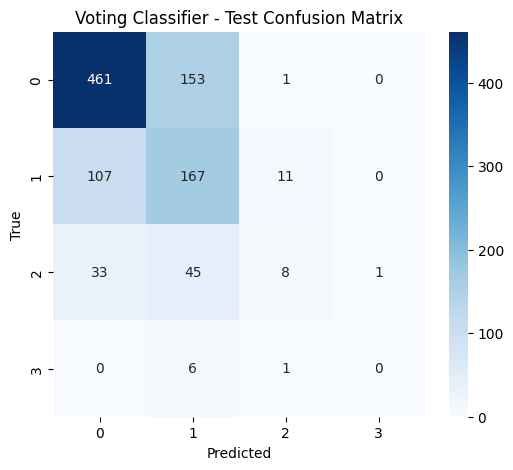

In [41]:
make_cm(y_test, y_test_pred, "Voting Classifier - Test")

## Model 1.5 - Stacking Classifier

In [42]:

# Create an ensemble using VotingClassifier with soft voting
ensemble_model = StackingClassifier(
    estimators=[('lgb', lgb_model), 
                ('xgb', xgb_model), 
                ('cat', catb_model)
                # ('rf', rf) 
                # ,('svc', svc)
                ],
    # weights=[4.0, 4.0, 5.0],
    n_jobs=-1
)

In [43]:
best_model = train_and_evaluate_classifier(ensemble_model, param_dist, n_iter=2)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .max_depth=6, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END .max_depth=4, min_samples_split=5, n_estimators=400; total time=   2.2s
[CV] END .max_depth=4, min_samples_split=5, n_estimators=400; total time=  13.2s
[CV] END .max_depth=6, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END cat__depth=4, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=10, xgb__max_depth=5, xgb__n_estimators=200; total time=  15.6s
[CV] END cat__depth=5, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=15, xgb__max_depth=5, xgb__n_estimators=300; total time=  10.8s
[CV] END cat__depth=4, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=10, xgb__max_depth=5, xgb__n_estimators=200; total time= 1.5min
[CV] END .max_depth=4, min_samples_split=5, n_estimators=400; total time=   2.4s
[CV] END .max_depth=6, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END .max_

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .max_depth=6, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END .max_depth=4, min_samples_split=5, n_estimators=400; total time=   2.2s
[CV] END .max_depth=6, min_samples_split=5, n_estimators=200; total time=  10.1s
[CV] END .max_depth=6, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END .max_depth=6, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END cat__depth=4, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=10, xgb__max_depth=5, xgb__n_estimators=200; total time=  15.7s
[CV] END cat__depth=5, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=15, xgb__max_depth=5, xgb__n_estimators=300; total time=  11.1s
[CV] END cat__depth=4, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=10, xgb__max_depth=5, xgb__n_estimators=200; total time= 1.5min
[CV] END cat__depth=5, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=15, xgb__max_depth=5, xgb__n_estimators=300; total time= 1.0min
Best Pa

In [44]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.3218
Test Accuracy: 0.5865
Test F1: 0.5859


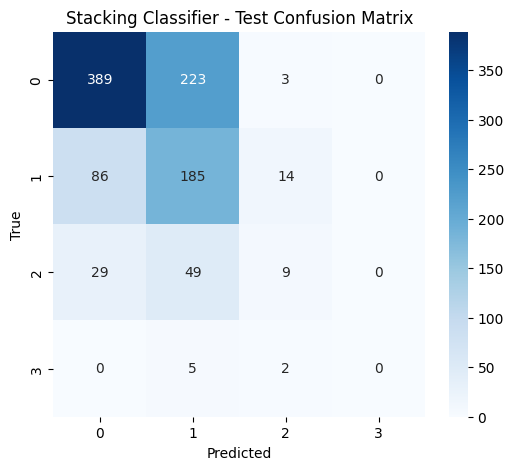

In [45]:
make_cm(y_test, y_test_pred, "Stacking Classifier - Test")

## Model 2 - Voting Regressor

In [46]:
# Function to apply thresholds to continuous predictions
def apply_thresholds(predictions, thresholds):
    return np.digitize(predictions, bins=thresholds)

# Function to optimize thresholds to maximize QWK
def optimize_thresholds(y_true, predictions):
    def loss_func(thresh):
        # Ensure thresholds are sorted
        thresh_sorted = np.sort(thresh)
        preds = apply_thresholds(predictions, thresh_sorted)
        return -quadratic_weighted_kappa(y_true, preds)
    
    initial_thresholds = [0.5, 1.5, 2.5]  # Initial guesses for thresholds
    bounds = [(0, 3)] * 3  # Assuming classes are 0,1,2,3
    result = minimize(loss_func, initial_thresholds, method='Nelder-Mead')
    return result.x

In [47]:
def train_and_evaluate_regressor(model, param_dist, n_iter=10, eval_metric=None):
    best_model, y_pred, y = train_and_evaluate(model, param_dist, n_iter, eval_metric)
    thresholds = optimize_thresholds(y, y_pred)
    y_pred = apply_thresholds(y_pred, thresholds)
    train_kappa = quadratic_weighted_kappa(y, y_pred)
    train_accuracy = accuracy_score(y, y_pred)
    train_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Best Train QWK: {train_kappa:.4f}")
    print(f"Best Train Accuracy: {train_accuracy:.4f}")
    print(f"Best Train F1: {train_f1:.4f}")
    return best_model, thresholds

In [48]:
svm = SVC(random_state=42)
xgb_model = XGBRegressor(random_state=42, verbosity=0, learning_rate=0.05)
lgb_model = LGBMRegressor(random_state=42, verbose=-1, learning_rate=0.05)
catb_model = CatBoostRegressor(random_state=42, verbose=False, learning_rate=0.05)

In [49]:
# Use the same ones as above for consistency
# param_dist = {
#             # 'rf__n_estimators': [100, 200, 300], 'rf__max_depth': [3], 'rf__min_samples_split': [2, 5, 10], 'rf__min_samples_leaf': [1], 'rf__max_features': ['auto', 'sqrt', 'log2'],
#             #   'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 'auto'], 'svc__kernel': ['linear', 'rbf'],
#               'xgb__n_estimators': [200, 300], 'xgb__max_depth': [2, 3],
#               'lgb__n_estimators': [100, 200], 'lgb__num_leaves': [5, 10],
#               'cat__iterations': [100, 200], 'cat__depth': [2, 4]
#               }

In [50]:
# Create an ensemble using VotingClassifier with soft voting
ensemble_model = VotingRegressor(
    estimators=[('lgb', lgb_model), 
                ('xgb', xgb_model), 
                ('cat', catb_model)
                # ('rf', rf) 
                # ,('svc', svc)
                ],
    # weights=[4.0, 4.0, 5.0],
    n_jobs=-1
)

In [51]:
best_model, thresholds = train_and_evaluate_regressor(ensemble_model, param_dist, n_iter=2)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'xgb__n_estimators': 200, 'xgb__max_depth': 5, 'lgb__num_leaves': 10, 'lgb__n_estimators': 100, 'cat__iterations': 200, 'cat__depth': 4}
Best Train QWK: 0.7540
Best Train Accuracy: 0.8146
Best Train F1: 0.8107


In [52]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
y_test_pred = apply_thresholds(y_test_pred, thresholds)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.3292
Test Accuracy: 0.5191
Test F1: 0.5335


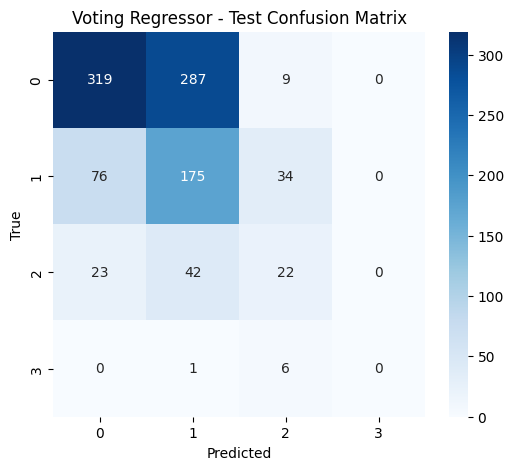

In [53]:
make_cm(y_test, y_test_pred, "Voting Regressor - Test")

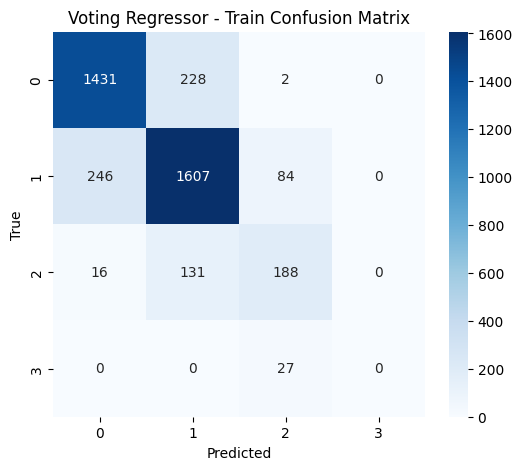

In [54]:
X_train = train_df.drop('sii', axis=1)
y_train = train_df['sii'].astype(int)
y_train_pred = best_model.predict(X_train)
y_train_pred = apply_thresholds(y_train_pred, thresholds)
make_cm(y_train, y_train_pred, "Voting Regressor - Train")

## Model 2.5 - Stacking Regressor

In [55]:
# Create an ensemble using VotingClassifier with soft voting
ensemble_model = StackingRegressor(
    estimators=[('lgb', lgb_model), 
                ('xgb', xgb_model), 
                ('cat', catb_model)
                # ('rf', rf) 
                # ,('svc', svc)
                ],
    # weights=[4.0, 4.0, 5.0],
    n_jobs=-1
)

In [56]:
best_model, thresholds = train_and_evaluate_regressor(ensemble_model, param_dist, n_iter=2)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .max_depth=6, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END .max_depth=6, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END .max_depth=6, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END .max_depth=6, min_samples_split=5, n_estimators=200; total time=   9.9s
[CV] END .max_depth=4, min_samples_split=5, n_estimators=400; total time=  11.6s
[CV] END cat__depth=5, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=15, xgb__max_depth=5, xgb__n_estimators=300; total time=  21.5s
[CV] END cat__depth=5, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=15, xgb__max_depth=5, xgb__n_estimators=300; total time= 1.9min
[CV] END cat__depth=5, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=15, xgb__max_depth=5, xgb__n_estimators=300; total time=   4.7s
[CV] END cat__depth=5, cat__iterations=200, lgb__n_estimators=100, lgb__num_leaves=15, xgb__max

In [57]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
y_test_pred = apply_thresholds(y_test_pred, thresholds)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.3454
Test Accuracy: 0.5221
Test F1: 0.5389


## Model 3 - TabNet

In [58]:

# Function that instantiates a tabnet model.
def create_tabnet(n_d=32, n_steps=5, lr=0.02, gamma=1.5, 
                  n_independent=2, n_shared=2, lambda_sparse=1e-4, 
                  momentum=0.3, is_classifier=True):
    if is_classifier:
        tabnet_model = TabNetClassifier(
            n_d=n_d,
            n_a=n_d,
            n_steps=n_steps,
            gamma=gamma,
            lambda_sparse=lambda_sparse,
            seed=2024,
            verbose=1,
            device_name='cuda',
            optimizer_fn=torch.optim.Adam,
            scheduler_params = {"gamma": 0.95,
                            "step_size": 20},
            scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
        )
    else:
        tabnet_model = TabNetRegressor(
            n_d=n_d,
            n_a=n_d,
            n_steps=n_steps,
            gamma=gamma,
            lambda_sparse=lambda_sparse,
            seed=2024,
            verbose=1,
            device_name='cuda',
            optimizer_fn=torch.optim.Adam,
            scheduler_params = {"gamma": 0.95,
                            "step_size": 20},
            scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
        )
    return tabnet_model
                  
def getBestTabNetModel(is_classifier):
    # Generate the parameter grid.
    param_grid = dict(n_d = [64],
                    n_a = [64],
                    n_steps = [3],
                    gamma = [1.3],
                    lambda_sparse = [1e-2, 1e-3, 1e-4],
                    momentum = [0.2],
                    n_shared = [2],
                    n_independent = [2],
    )

    grid = ParameterGrid(param_grid)

    search_results = pd.DataFrame() 
    best_score = -np.inf
    best_model = None
    for params in tqdm(grid, desc="Hyperparameter Search", ncols=100):
        X_train, X_val, y_train, y_val = train_test_split(X.values.astype(np.float32), y.values.astype(np.int8), test_size=0.2, stratify=y)
        if is_classifier == False:
            y_train = y_train.reshape(-1, 1)
            y_val = y_val.reshape(-1, 1)
            eval_metric = ['rmse']
        else:
            eval_metric = ['logloss']
        tqdm.write(f"Before training - y_train shape: {str(y_train.shape)}, y_val shape: {str(y_val.shape)}")
        params['n_a'] = params['n_d'] # n_a=n_d always per the paper
        tabnet = create_tabnet(is_classifier=is_classifier)
        tabnet.set_params(**params)
        tabnet.fit(X_train=X_train, y_train=y_train, eval_set=[(X_val, y_val)], eval_name=['validation'], eval_metric=eval_metric, max_epochs=200, patience=20,
                batch_size=1024, virtual_batch_size=128)
        if is_classifier:
            y_pred = np.argmax(tabnet.predict_proba(X_val), axis=1)
            score = quadratic_weighted_kappa(y_val, y_pred)  # Convert probabilities to class labels and calculate accuracy
        else:
            y_pred = tabnet.predict(X_val)
            score = np.sqrt(mean_squared_error(y_val.astype(np.float32), y_pred))
        if score > best_score:
            best_model = tabnet
            best_score = score
    return best_model

### Classifier

In [59]:
best_model = getBestTabNetModel(is_classifier=True)

Hyperparameter Search:   0%|                                                  | 0/3 [00:00<?, ?it/s]

Before training - y_train shape: (3168,), y_val shape: (792,)
epoch 0  | loss: 1.52097 | validation_logloss: 6.24402 |  0:00:00s
epoch 1  | loss: 1.03592 | validation_logloss: 4.08199 |  0:00:00s
epoch 2  | loss: 0.89744 | validation_logloss: 2.17063 |  0:00:00s
epoch 3  | loss: 0.89538 | validation_logloss: 2.7993  |  0:00:01s
epoch 4  | loss: 0.79217 | validation_logloss: 3.00972 |  0:00:01s
epoch 5  | loss: 0.77497 | validation_logloss: 4.26276 |  0:00:01s
epoch 6  | loss: 0.74357 | validation_logloss: 3.48745 |  0:00:01s
epoch 7  | loss: 0.71596 | validation_logloss: 2.77937 |  0:00:01s
epoch 8  | loss: 0.70605 | validation_logloss: 7.35169 |  0:00:01s
epoch 9  | loss: 0.6911  | validation_logloss: 4.19602 |  0:00:01s
epoch 10 | loss: 0.68144 | validation_logloss: 2.32537 |  0:00:02s
epoch 11 | loss: 0.67486 | validation_logloss: 4.06167 |  0:00:02s
epoch 12 | loss: 0.66487 | validation_logloss: 3.48551 |  0:00:02s
epoch 13 | loss: 0.64111 | validation_logloss: 2.87447 |  0:00:02s


Hyperparameter Search:  33%|██████████████                            | 1/3 [00:15<00:31, 15.94s/it]

Before training - y_train shape: (3168,), y_val shape: (792,)
epoch 0  | loss: 1.51249 | validation_logloss: 8.71248 |  0:00:00s
epoch 1  | loss: 1.02732 | validation_logloss: 3.65046 |  0:00:00s
epoch 2  | loss: 0.95455 | validation_logloss: 3.49633 |  0:00:00s
epoch 3  | loss: 0.84383 | validation_logloss: 5.08956 |  0:00:00s
epoch 4  | loss: 0.7932  | validation_logloss: 3.42987 |  0:00:00s
epoch 5  | loss: 0.75513 | validation_logloss: 2.66579 |  0:00:00s
epoch 6  | loss: 0.7133  | validation_logloss: 2.42403 |  0:00:00s
epoch 7  | loss: 0.68957 | validation_logloss: 2.1367  |  0:00:01s
epoch 8  | loss: 0.68022 | validation_logloss: 2.07505 |  0:00:01s
epoch 9  | loss: 0.65987 | validation_logloss: 1.65289 |  0:00:01s
epoch 10 | loss: 0.65509 | validation_logloss: 1.829   |  0:00:01s
epoch 11 | loss: 0.6337  | validation_logloss: 2.02141 |  0:00:01s
epoch 12 | loss: 0.6196  | validation_logloss: 1.68369 |  0:00:01s
epoch 13 | loss: 0.61425 | validation_logloss: 1.63002 |  0:00:01s


Hyperparameter Search:  67%|████████████████████████████              | 2/3 [00:27<00:13, 13.34s/it]

Before training - y_train shape: (3168,), y_val shape: (792,)
epoch 0  | loss: 1.52241 | validation_logloss: 7.60384 |  0:00:00s
epoch 1  | loss: 1.03847 | validation_logloss: 2.21003 |  0:00:00s
epoch 2  | loss: 0.9039  | validation_logloss: 3.62123 |  0:00:00s
epoch 3  | loss: 0.83174 | validation_logloss: 5.28705 |  0:00:00s
epoch 4  | loss: 0.80001 | validation_logloss: 3.37835 |  0:00:00s
epoch 5  | loss: 0.76065 | validation_logloss: 4.34097 |  0:00:00s
epoch 6  | loss: 0.72126 | validation_logloss: 3.44033 |  0:00:00s
epoch 7  | loss: 0.71285 | validation_logloss: 1.35778 |  0:00:01s
epoch 8  | loss: 0.69205 | validation_logloss: 1.37743 |  0:00:01s
epoch 9  | loss: 0.66364 | validation_logloss: 1.56861 |  0:00:01s
epoch 10 | loss: 0.66102 | validation_logloss: 1.78694 |  0:00:01s
epoch 11 | loss: 0.6389  | validation_logloss: 1.98642 |  0:00:01s
epoch 12 | loss: 0.60911 | validation_logloss: 2.70633 |  0:00:01s
epoch 13 | loss: 0.61169 | validation_logloss: 2.15398 |  0:00:01s


Hyperparameter Search: 100%|██████████████████████████████████████████| 3/3 [00:31<00:00, 10.49s/it]

epoch 27 | loss: 0.51612 | validation_logloss: 1.69033 |  0:00:03s

Early stopping occurred at epoch 27 with best_epoch = 7 and best_validation_logloss = 1.35778


In [60]:
train_X = X.values.astype(np.float32)
train_pred = np.argmax(best_model.predict_proba(train_X), axis=1)

train_kappa = quadratic_weighted_kappa(y, train_pred)
train_accuracy = accuracy_score(y, train_pred)
train_f1 = f1_score(y, train_pred, average='weighted')

print(f"Best Train QWK: {train_kappa:.4f}")
print(f"Best Train Accuracy: {train_accuracy:.4f}")
print(f"Best Train F1: {train_f1:.4f}")

Best Train QWK: 0.5198
Best Train Accuracy: 0.7409
Best Train F1: 0.7325


In [61]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
test_X = X_test.values.astype(np.float32)
y_test_pred = np.argmax(best_model.predict_proba(test_X), axis=1)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Best Test QWK: {test_kappa:.4f}")
print(f"Best Train Accuracy: {test_accuracy:.4f}")
print(f"Best Train F1: {test_f1:.4f}")


Best Test QWK: 0.0841
Best Train Accuracy: 0.4648
Best Train F1: 0.4762


In [62]:
best_model

TabNetClassifier(n_d=64, n_a=64, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.2, lambda_sparse=0.01, seed=2024, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.95, 'step_size': 20}, mask_type='sparsemax', input_dim=103, output_dim=4, device_name='cuda', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

### Regressor

In [63]:
y.values.astype(np.int8).reshape(-1, 1).shape

(3960, 1)

In [64]:
best_model = getBestTabNetModel(is_classifier=False)

Hyperparameter Search:   0%|                                                  | 0/3 [00:00<?, ?it/s]

Before training - y_train shape: (3168, 1), y_val shape: (792, 1)
epoch 0  | loss: 4.46933 | validation_rmse: 27.56464958190918|  0:00:00s
epoch 1  | loss: 1.61257 | validation_rmse: 27.22150993347168|  0:00:00s
epoch 2  | loss: 1.00435 | validation_rmse: 12.296310424804688|  0:00:00s
epoch 3  | loss: 0.83153 | validation_rmse: 4.299849987030029|  0:00:00s
epoch 4  | loss: 0.61276 | validation_rmse: 6.445459842681885|  0:00:00s
epoch 5  | loss: 0.5551  | validation_rmse: 4.436669826507568|  0:00:01s
epoch 6  | loss: 0.50638 | validation_rmse: 6.835790157318115|  0:00:01s
epoch 7  | loss: 0.50093 | validation_rmse: 3.029550075531006|  0:00:01s
epoch 8  | loss: 0.48379 | validation_rmse: 1.3972599506378174|  0:00:01s
epoch 9  | loss: 0.41659 | validation_rmse: 1.3805899620056152|  0:00:01s
epoch 10 | loss: 0.37433 | validation_rmse: 1.1987899541854858|  0:00:01s
epoch 11 | loss: 0.37103 | validation_rmse: 1.1002700328826904|  0:00:01s
epoch 12 | loss: 0.35922 | validation_rmse: 1.0131100

Hyperparameter Search:  33%|██████████████                            | 1/3 [00:14<00:29, 14.87s/it]

epoch 97 | loss: 0.15014 | validation_rmse: 0.6262400150299072|  0:00:14s

Early stopping occurred at epoch 97 with best_epoch = 77 and best_validation_rmse = 0.6136599779129028
Before training - y_train shape: (3168, 1), y_val shape: (792, 1)
epoch 0  | loss: 4.60862 | validation_rmse: 28.2367000579834|  0:00:00s
epoch 1  | loss: 1.56319 | validation_rmse: 11.183770179748535|  0:00:00s
epoch 2  | loss: 0.91949 | validation_rmse: 6.820720195770264|  0:00:00s
epoch 3  | loss: 0.73939 | validation_rmse: 8.52908992767334|  0:00:00s
epoch 4  | loss: 0.69112 | validation_rmse: 1.24058997631073|  0:00:00s
epoch 5  | loss: 0.5267  | validation_rmse: 0.8463299870491028|  0:00:00s
epoch 6  | loss: 0.47522 | validation_rmse: 0.8309900164604187|  0:00:01s
epoch 7  | loss: 0.41653 | validation_rmse: 0.7147700190544128|  0:00:01s
epoch 8  | loss: 0.38948 | validation_rmse: 0.7497400045394897|  0:00:01s
epoch 9  | loss: 0.37639 | validation_rmse: 0.891480028629303|  0:00:01s
epoch 10 | loss: 0.34801

Hyperparameter Search:  67%|████████████████████████████              | 2/3 [00:19<00:08,  8.76s/it]

Before training - y_train shape: (3168, 1), y_val shape: (792, 1)
epoch 0  | loss: 4.92137 | validation_rmse: 17.54269027709961|  0:00:00s
epoch 1  | loss: 1.45306 | validation_rmse: 18.79380989074707|  0:00:00s
epoch 2  | loss: 0.99615 | validation_rmse: 5.8201398849487305|  0:00:00s
epoch 3  | loss: 0.75197 | validation_rmse: 3.631659984588623|  0:00:00s
epoch 4  | loss: 0.57861 | validation_rmse: 5.8150200843811035|  0:00:00s
epoch 5  | loss: 0.52159 | validation_rmse: 3.507930040359497|  0:00:00s
epoch 6  | loss: 0.53841 | validation_rmse: 1.9781099557876587|  0:00:01s
epoch 7  | loss: 0.46349 | validation_rmse: 1.7652000188827515|  0:00:01s
epoch 8  | loss: 0.43057 | validation_rmse: 2.0100901126861572|  0:00:01s
epoch 9  | loss: 0.40429 | validation_rmse: 1.1165200471878052|  0:00:01s
epoch 10 | loss: 0.38123 | validation_rmse: 0.9399399757385254|  0:00:01s
epoch 11 | loss: 0.35943 | validation_rmse: 1.591599941253662|  0:00:01s
epoch 12 | loss: 0.37284 | validation_rmse: 1.20332

Hyperparameter Search: 100%|██████████████████████████████████████████| 3/3 [00:25<00:00,  8.47s/it]


In [65]:
raw_preds = best_model.predict(X.values.astype(np.float32))
thresholds = optimize_thresholds(y.values.astype(np.float32), raw_preds)
train_pred = apply_thresholds(raw_preds, thresholds)

train_kappa = quadratic_weighted_kappa(y, train_pred)
train_accuracy = accuracy_score(y, train_pred)
train_f1 = f1_score(y, train_pred, average='weighted')

print(f"Best Train QWK: {train_kappa:.4f}")
print(f"Best Train Accuracy: {train_accuracy:.4f}")
print(f"Best Train F1: {train_f1:.4f}")

Best Train QWK: -0.0383
Best Train Accuracy: 0.3755
Best Train F1: 0.3416


In [66]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
test_X = X_test.values.astype(np.float32)
raw_preds = best_model.predict(test_X)
y_test_pred = apply_thresholds(raw_preds, thresholds)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Best Test QWK: {test_kappa:.4f}")
print(f"Best Train Accuracy: {test_accuracy:.4f}")
print(f"Best Train F1: {test_f1:.4f}")

Best Test QWK: -0.0339
Best Train Accuracy: 0.4195
Best Train F1: 0.4180
